# Casting Defects with Autoencoders (Novelty Detection)

Now, we will be using autoencoder, a type of neural network.
This project is heavily influenced by the tutorial on autoencoders by official TensorFlow docs: [Intro to Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.models import Model
from tensorflow.math import less

## Data Transformation

In [2]:
def quantify_image(img):
    # compute a greyscale histogram over an image and normalize it
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist.tolist()

In [3]:
def transform_data_from_path(imagePath):
    # convert all images in the imagePath
    # to greyscale histogram values (normalised)
    data = []

    # loop over the imagePath directory
    for imageName in os.listdir(imagePath):
        # load the image
        image = cv2.imread(imagePath + '\\' + imageName)
        # quantify the image and update the data list
        features = quantify_image(image)
        data.append(features)
    return np.array(data)

As deep learning performs better for large datasets, we will use the augmented image set instead of raw image set.

In [4]:
# The paths to the images
defect_path = os.path.join('casting_data', 'train', 'def_front')
normal_path = os.path.join('casting_data', 'train', 'ok_front')

In [5]:
defect = transform_data_from_path(defect_path)
normal = transform_data_from_path(normal_path)

print('Defect:', len(defect))
print('Normal:', len(normal))

Defect: 3758
Normal: 2875


As we are using <strong>novelty detection</strong> method, we will train the autoencoder using only the normal casting. So, we will separate the normal casting from the defected casting.

In [6]:
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=42)
defect_train, defect_test = train_test_split(defect, test_size=0.2, random_state=42)

print('Normal')
print('Train:', len(normal_train))
print('Test:', len(normal_test))

print()
print('Defective')
print('Train:', len(defect_train))
print('Test:', len(defect_test))

Normal
Train: 2300
Test: 575

Defective
Train: 3006
Test: 752


Let's plot a normal casting greyscale histogram.

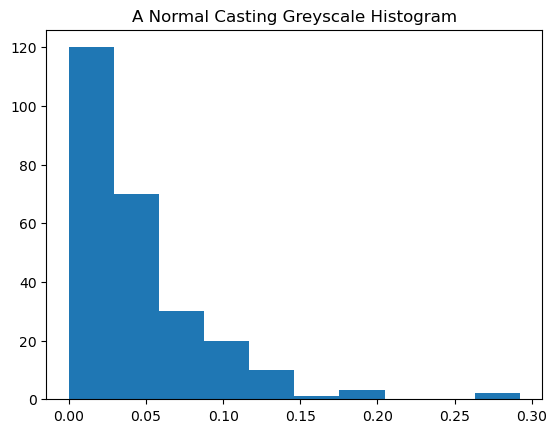

In [7]:
plt.hist(normal_train[0])
plt.title("A Normal Casting Greyscale Histogram")
plt.show()

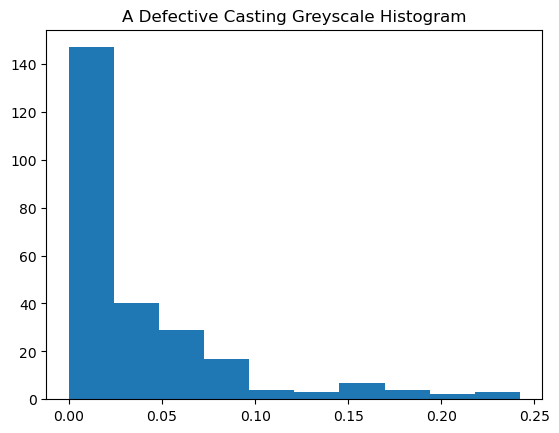

In [8]:
plt.hist(defect_train[0])
plt.title("A Defective Casting Greyscale Histogram")
plt.show()

## Model Training

In [9]:
class NoveltyDetector(Model):
  def __init__(self):
    super(NoveltyDetector, self).__init__()
    self.encoder = Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
    ])

    self.decoder = Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(256, activation="sigmoid")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [10]:
autoencoder = NoveltyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

The autoencoder is trained using only the normal casting, but is evaluated using the full test set.

In [11]:
test = np.concatenate((normal_test, defect_test), axis=0)

# True means normal casting while False means defective casting
test_labels = np.full(len(test), True, dtype=bool)
test_labels[-len(defect_test):] = False

print(len(test))

1327


In [12]:
history = autoencoder.fit(normal_train, normal_train, 
          epochs=30, 
          batch_size=32,
          validation_data=(test, test),
          shuffle=False,
          verbose=0)

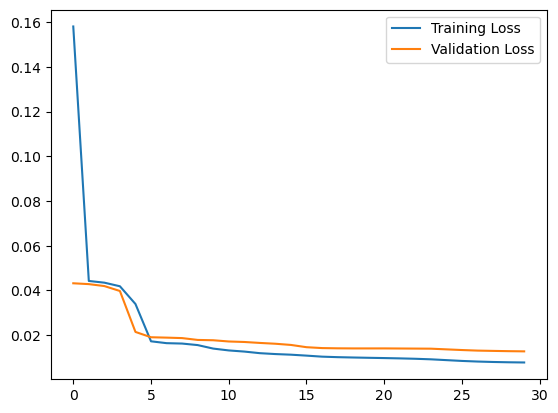

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Now, we have the trained model. Let's see how the model performs on one normal casting and one defective casting images.

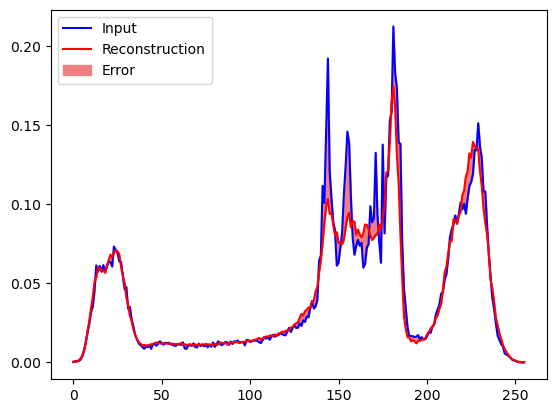

In [14]:
encoded_data = autoencoder.encoder(normal_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

# Plot and compare the original and reconstructed first image for normal casting
plt.plot(normal_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(256), decoded_data[0], normal_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

It seems like the reconstruction error for one normal casting image is low. Let's do the same for defective casting image.

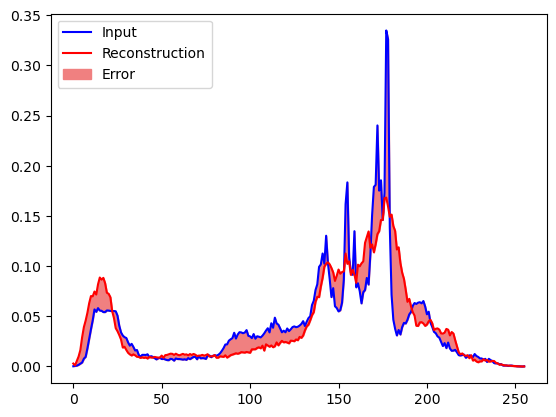

In [15]:
encoded_data = autoencoder.encoder(defect_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

# Plot and compare the original and reconstructed first image for defective casting
plt.plot(defect_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(256), decoded_data[0], defect_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In contrast, the reconstruction error for one defective casting image is higher. We can use this observation to detect defective casting.

## Detect Anomalies/Novelty

We will detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. For this, we will calculate the mean average error for normal samples from the training set, then classify future examples as anomalous (defective) if the reconstruction error is higher than one standard deviation from the training set.

72/72 [==============================] - 0s 3ms/step


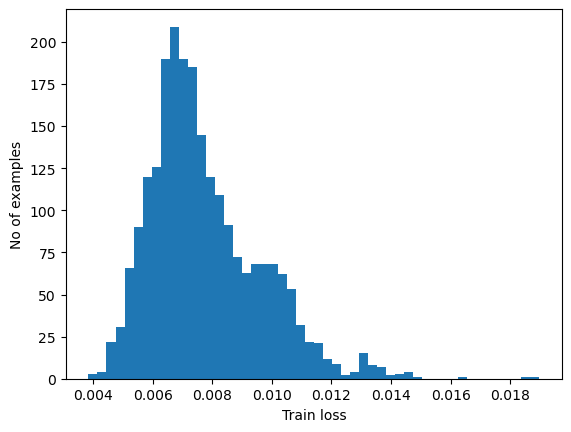

In [16]:
reconstructions = autoencoder.predict(normal_train)
train_loss = losses.mae(reconstructions, normal_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

The reconstruction errors for the train samples are concentrated between 0.006 and 0.010.

In [17]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.009604018140722871


24/24 [==============================] - 0s 4ms/step


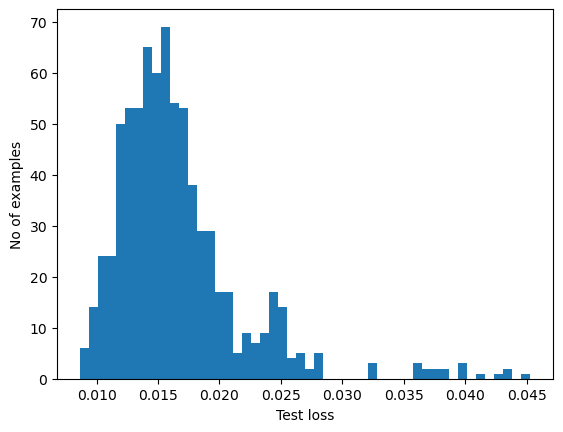

In [18]:
reconstructions = autoencoder.predict(defect_test)
test_loss = losses.mae(reconstructions, defect_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

The reconstruction errors for the defective test samples are concentrated between 0.012 and 0.019.

In [19]:
reconstructions = autoencoder.predict(test)
loss = losses.mae(reconstructions, test)
preds = less(loss, threshold)

42/42 [==============================] - 0s 3ms/step


In [20]:
print(classification_report(test_labels, preds, target_names=['Defective', 'Normal']))

              precision    recall  f1-score   support

   Defective       0.88      0.99      0.93       752
      Normal       0.98      0.82      0.89       575

    accuracy                           0.91      1327
   macro avg       0.93      0.90      0.91      1327
weighted avg       0.92      0.91      0.91      1327



Compared to all other models, we can see that autoencoder model achieves a high accuracy of 0.91. The recalls for both defective and normal casting are also high, at 0.99 and 0.82 respectively.

Now, we will try the threshold values in the range of [0.01, 0.013).

In [21]:
optimal_th = 0
max_accuracy = -1
for threshold in np.arange(0.01, 0.013, 0.0001):
    preds = less(loss, threshold)
    accuracy = accuracy_score(test_labels, preds)
    if(accuracy > max_accuracy):
        max_accuracy = accuracy
        optimal_th = threshold
    print(f'threshold: {threshold: .4f}, accuracy: {accuracy}')

threshold:  0.0100, accuracy: 0.920120572720422
threshold:  0.0101, accuracy: 0.9246420497362472
threshold:  0.0102, accuracy: 0.9276563677467973
threshold:  0.0103, accuracy: 0.9306706857573473
threshold:  0.0104, accuracy: 0.93293142426526
threshold:  0.0105, accuracy: 0.9366993217784476
threshold:  0.0106, accuracy: 0.9359457422758101
threshold:  0.0107, accuracy: 0.9344385832705351
threshold:  0.0108, accuracy: 0.9351921627731725
threshold:  0.0109, accuracy: 0.9382064807837227
threshold:  0.0110, accuracy: 0.9404672192916352
threshold:  0.0111, accuracy: 0.9412207987942728
threshold:  0.0112, accuracy: 0.9397136397889977
threshold:  0.0113, accuracy: 0.9397136397889977
threshold:  0.0114, accuracy: 0.9397136397889977
threshold:  0.0115, accuracy: 0.9389600602863603
threshold:  0.0116, accuracy: 0.9374529012810852
threshold:  0.0117, accuracy: 0.9397136397889977
threshold:  0.0118, accuracy: 0.9351921627731725
threshold:  0.0119, accuracy: 0.9284099472494348
threshold:  0.0120, acc

The best autoencoder model occurs at threshold = 0.0111 with accuracy of 0.94.

In [22]:
preds = less(loss, optimal_th)
print(classification_report(test_labels, preds, target_names=['Defective', 'Normal']))

              precision    recall  f1-score   support

   Defective       0.96      0.93      0.95       752
      Normal       0.92      0.95      0.93       575

    accuracy                           0.94      1327
   macro avg       0.94      0.94      0.94      1327
weighted avg       0.94      0.94      0.94      1327



However, the best overall autoencoder model has one tradeoff. The recall for defective casting has decreased from 0.99 to 0.93 while that for normal casting has increased from 0.82 to 0.95.